In [1]:
import numpy as np
import sys,os
sys.path.append(os.getcwd()[:-11]+'src/')
from models import *
from topological_methods import *
import matplotlib.pyplot as plt
clrs = plt.cm.tab20.colors

In [2]:
#Plots for normal initialization
import math

mean = 0
std = 0.1
n_perms = 100
out_dims = [2,5,10,25,50,100]#,500,1000]
in_dims = [2,5,10,25,50,100]

#eval points
res = 100
lims = 5

region_ranks = np.zeros([len(in_dims),len(out_dims),n_perms])
rank_est = np.zeros([len(in_dims),len(out_dims),n_perms])
for m, dim_in in enumerate(in_dims):
    for n, dim_out in enumerate(out_dims):
        for l in range(n_perms):
            x = torch.Tensor(lims*2*(np.random.rand(dim_in, res)-0.5)).T
            rand_model = FeedforwardNetwork(input_size=dim_in,hidden_sizes=[dim_out],mean=mean,std=1/np.sqrt(dim_out), init_type='none')
            out = rand_model(x)[0]
            out_code = torch.sign(out).unique(dim=0)#[torch.sum(out[i]>0,axis=1) for i in range(len(out))]
            region_ranks[m,n,l] = min(rand_model.compute_rank(out_code))
#            region_ranks[m,n,l] = sum(out_code[0]<dim_in).item()>0

In [757]:
from sklearn.manifold import MDS

def code_equivalence_class(code,ranks,min_rank=2): #function to compute equivalence classes
    uniq_els = np.unique(code, return_inverse=True,axis=0)
    code_list = [[] for i in range(len(uniq_els[0]))]
    uniq_code = uniq_els[1]
    uniq_code[ranks<min_rank] = 0
    #uniq_code = uniq_code/np.max(uniq_code)
    for i, uind in enumerate(uniq_els[1]):
        if ranks[i]<min_rank:
            code_list[uind].append(i)
    code_list = [code_list[i] for i in range(len(code_list)) if len(code_list[i])>1]
    return code_list, uniq_code

res = 1024

Phom = PersistentHomology()
reducer = MDS(n_components=3, normalized_stress='auto',dissimilarity='precomputed')
#Isomap(n_components=3,n_neighbors=4,metric='precomputed')
metric = pairwise_distances#GeodesicKNN(k=8,adaptive=True).fit
Mfld = ManifoldGenerator()
S1 = torch.Tensor(Mfld.S1(res,1))
T2 = torch.Tensor(Mfld.T2(int(np.sqrt(res)),1,0.5))

codes_S1 = np.zeros([len(in_dims),len(out_dims),res])
codes_T2 = np.zeros([len(in_dims),len(out_dims),res])

out_dims = [2,3,5,200]
in_dims = [2,3,5,200]
n_perms = 1

region_ranks_S1 = np.zeros([len(in_dims),len(out_dims),n_perms,res])
region_ranks_T2 = np.zeros([len(in_dims),len(out_dims),n_perms,res])

S1_dmats = []
T2_dmats = []

S1_pdiags = []
T2_pdiags = []

S1_dmats_rel = []
T2_dmats_rel = []

S1_pdiags_rel = []
T2_pdiags_rel = []

S1_mflds = []
T2_mflds = []

S1_mflds_rel = []
T2_mflds_rel = []

for n, dim_out in enumerate(out_dims):
    for m, dim_in in enumerate(in_dims):
        for l in range(n_perms):
            x = torch.Tensor(np.random.randn(dim_in, 3)).T
            S1_emb = S1.T@x[:2]
            T2_emb = T2.T@x
            rand_model = FeedforwardNetwork(input_size=dim_in,hidden_sizes=[dim_out], init_type='none')
            out_S1 = rand_model(S1_emb)[0]
            out_T2 = rand_model(T2_emb)[0]

            out_code_S1 = torch.sign(out_S1)
            out_code_T2 = torch.sign(out_T2)
            
            region_ranks_S1[m,n,l] = rand_model.compute_rank(out_code_S1)
            region_ranks_T2[m,n,l] = rand_model.compute_rank(out_code_T2)

            id_points_S1 = code_equivalence_class(out_code_S1.detach().numpy(),region_ranks_S1[m,n,l],min_rank=2)
            id_points_T2 = code_equivalence_class(out_code_T2.detach().numpy(),region_ranks_T2[m,n,l],min_rank=3)

            codes_S1[m,n] = id_points_S1[1]
            codes_T2[m,n] = id_points_T2[1]

            if len(id_points_S1[0])==0:
                S1_rel = Phom.relative_homology(S1.T,[[0]],metric,False,[1,250])
            elif len(id_points_S1)==res:
                S1_rel = Phom.relative_homology(S1.T,[np.arrange(0,res-1)],metric,False,[1,None])
            else:
                S1_rel = Phom.relative_homology(S1.T,id_points_S1[0],metric,False,[1,None])
            S1_hom = Phom.homology_analysis(out_S1.detach(),metric,False,[1,250])
                
            S1_dmats.append(S1_hom[0])
            S1_pdiags.append(S1_hom[1])
            S1_dmats_rel.append(S1_rel[0])
            S1_pdiags_rel.append(S1_rel[1])
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                S1_mflds.append(reducer.fit_transform(S1_dmats[-1]))
                S1_mflds_rel.append(reducer.fit_transform(S1_dmats_rel[-1]))

            if len(id_points_T2[0])==0:
                T2_rel = Phom.relative_homology(T2.T,[[0]],metric,False,[2,250])
            elif len(id_points_T2)==res:
                T2_rel = Phom.relative_homology(T2.T,[np.arrange(0,res-1)],metric,False,[2,None])
            else:
                T2_rel = Phom.relative_homology(T2.T,id_points_T2[0],metric,False,[2,None])
            T2_hom = Phom.homology_analysis(out_T2.detach(),metric,False,[2,250])
            
            T2_dmats.append(T2_hom[0])
            T2_pdiags.append(T2_hom[1])
            T2_dmats_rel.append(T2_rel[0])
            T2_pdiags_rel.append(T2_rel[1])
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                T2_mflds.append(reducer.fit_transform(T2_dmats[-1]))
                T2_mflds_rel.append(reducer.fit_transform(T2_dmats_rel[-1]))
        

In [758]:
from matplotlib.colors import LinearSegmentedColormap

custom_colormap = LinearSegmentedColormap.from_list('rank_decomp',['#c0bbffff','#bbfaffff','#ffbbbbff','#fff4bbff'])

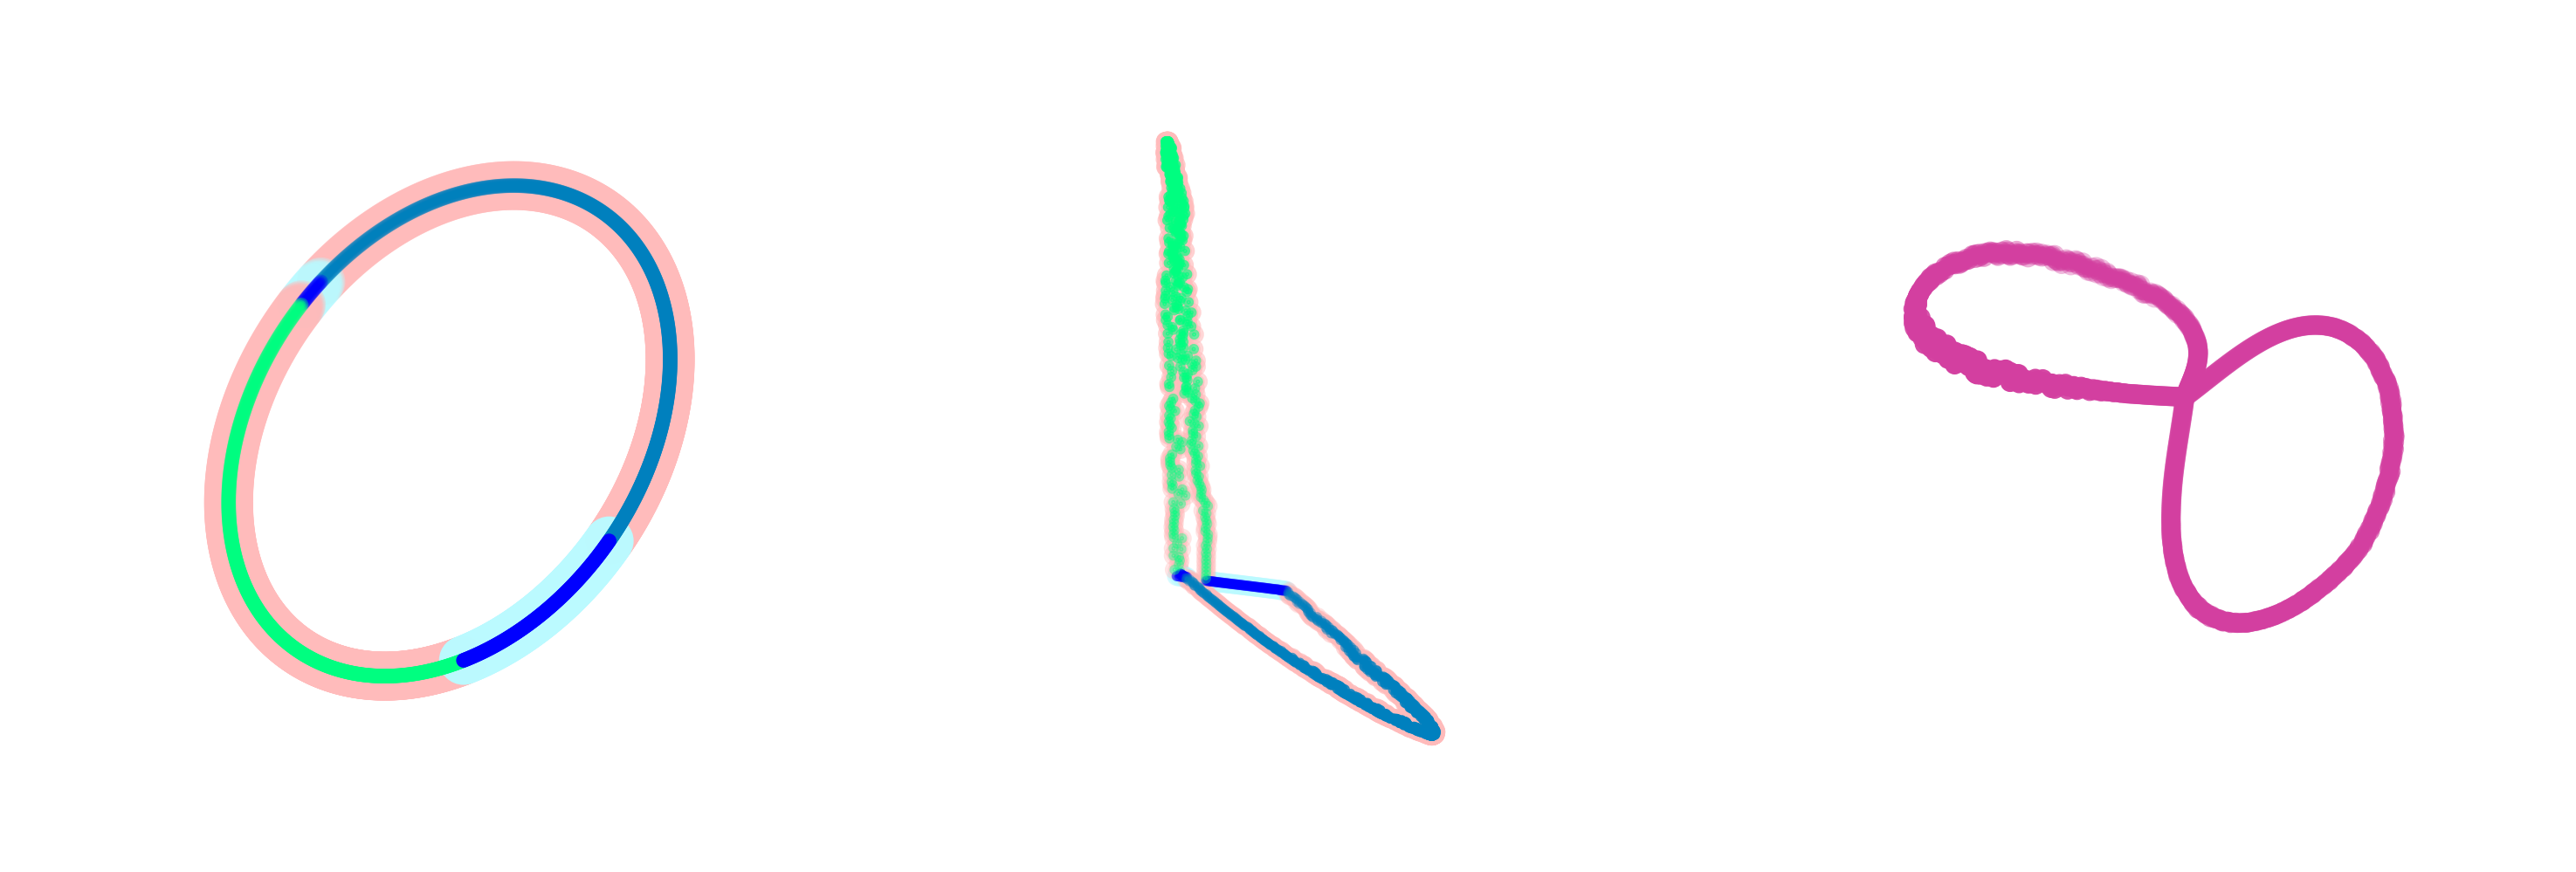

In [830]:
id = 5
fig,ax = plt.subplots(1,3,subplot_kw=dict(projection='3d'),figsize=(6,6),dpi=500)
ax[0].scatter(S1[0],
            S1[1],
            S1[1],
            s=50,vmin=0,vmax=3,
            c=region_ranks_S1[id%4,int(np.floor(id/4))],cmap=custom_colormap)
ax[0].scatter(S1[0],
            S1[1],
            S1[1],
            s=2,c=codes_S1[id%4,int(np.floor(id/4))],cmap='winter')
ax[0].axis('off')
ax[1].view_init(elev=100, azim=290)
ax[1].scatter(S1_mflds[id][:,0],
            S1_mflds[id][:,1],
            S1_mflds[id][:,2],
            s=5,vmin=0,vmax=3,
            c=region_ranks_S1[id%4,int(np.floor(id/4))],cmap=custom_colormap)
ax[1].scatter(S1_mflds[id][:,0],
            S1_mflds[id][:,1],
            S1_mflds[id][:,2],
            s=0.5,c=codes_S1[id%4,int(np.floor(id/4))],cmap='winter')
ax[1].axis('off')
ax[2].scatter(S1_mflds_rel[id][:,0],
            S1_mflds_rel[id][:,1],
            S1_mflds_rel[id][:,2],
            s=5,c='#d33fa0ff')
ax[2].axis('off')
fig.tight_layout()
fig.savefig("/Users/kosio/Figures/MfldClassification/S1_examples.png",dpi=500, transparent=True)

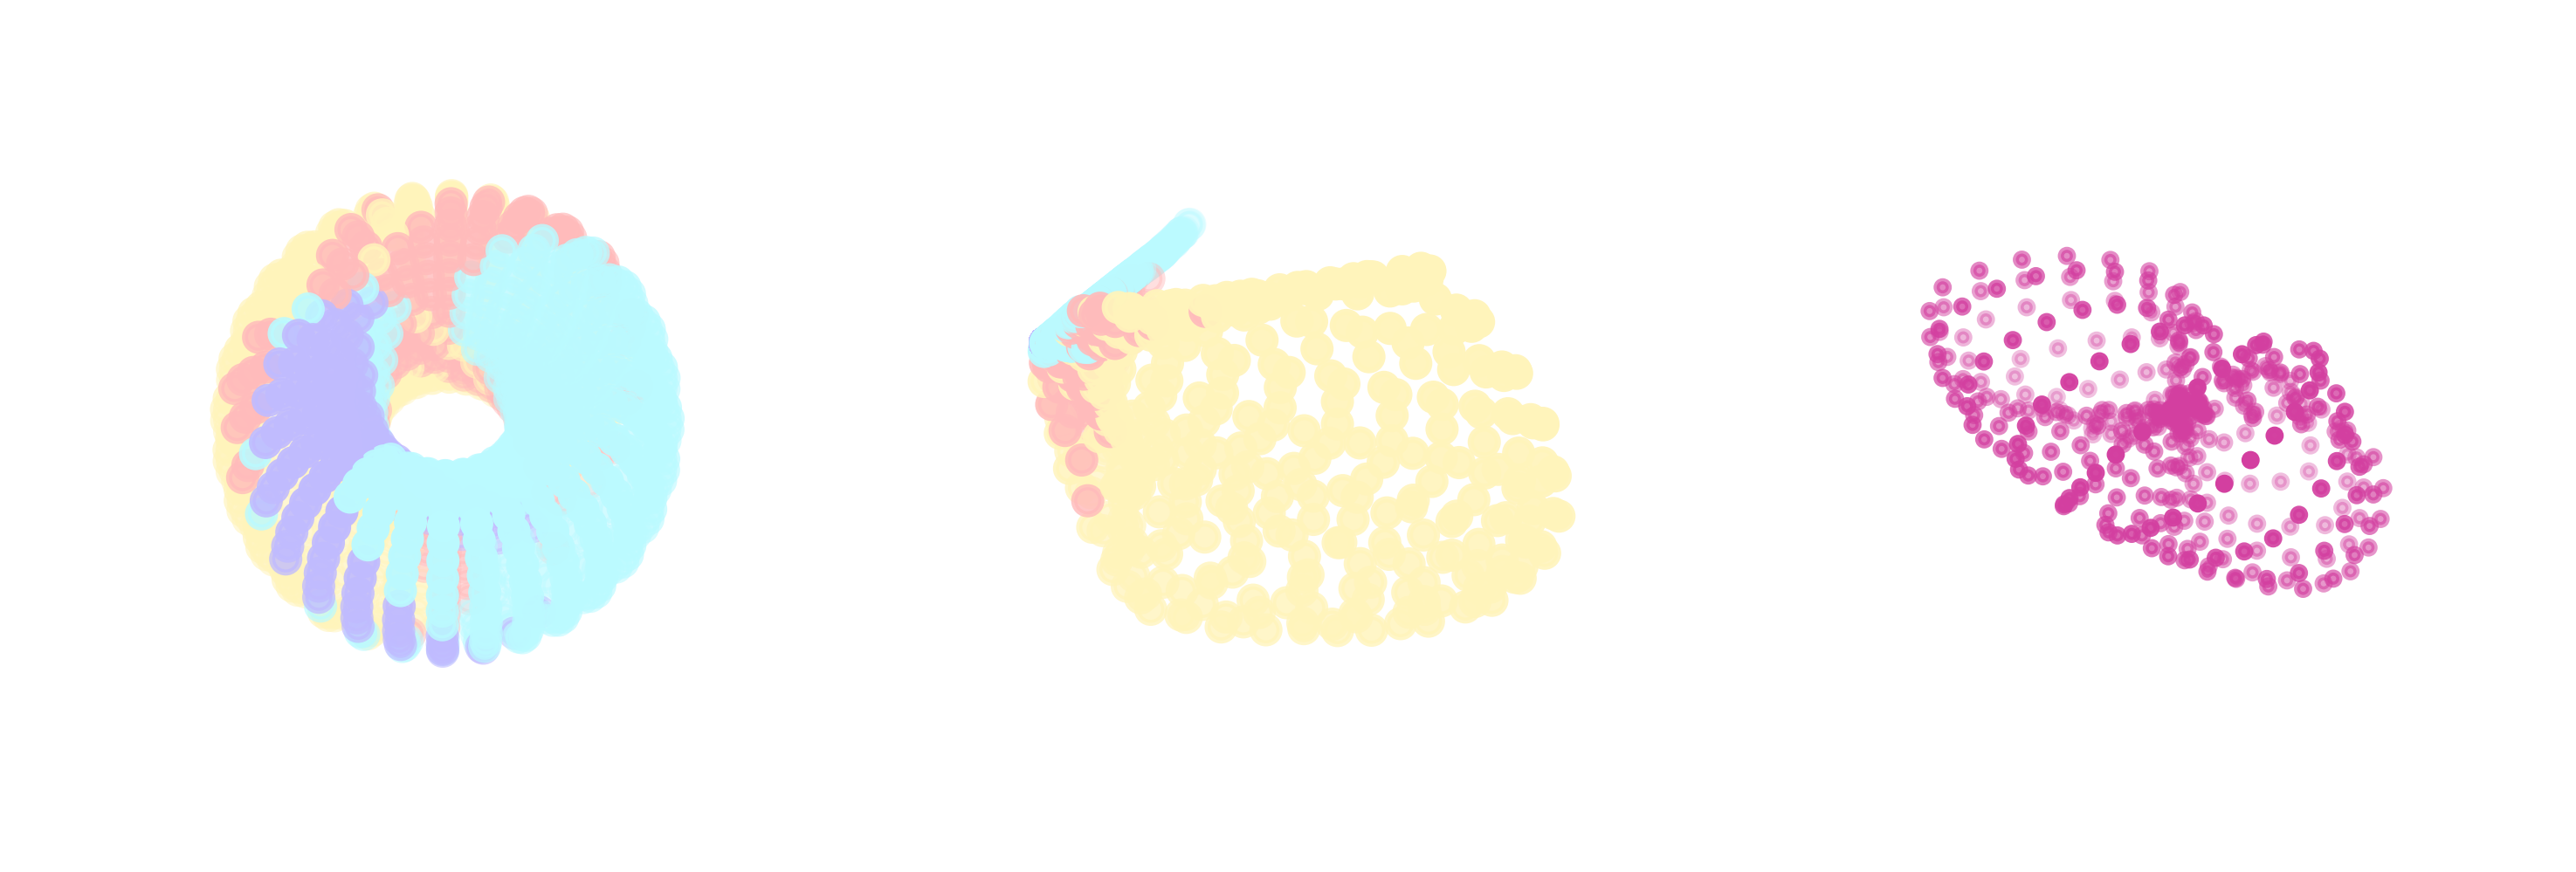

In [832]:
id = 10
fig,ax = plt.subplots(1,3,subplot_kw=dict(projection='3d'),figsize=(6,6),dpi=500)
ax[0].view_init(elev=250, azim=100)
ax[0].scatter(T2[0],
            T2[1],
            T2[2],
            s=20,vmin=0,vmax=3,
            c=region_ranks_T2[id%4,int(np.floor(id/4))],cmap=custom_colormap)
#ax[0].scatter(T2[0],
#            T2[1],
#            T2[2],
#            s=2,c=codes_T2[id%4,int(np.floor(id/4))],cmap='winter')
ax[0].axis('off')
ax[1].view_init(elev=280, azim=120)
ax[1].scatter(T2_mflds[id][:,0],
            T2_mflds[id][:,1],
            T2_mflds[id][:,2],
            s=20,vmin=0,vmax=3,
            c=region_ranks_T2[id%4,int(np.floor(id/4))],cmap=custom_colormap)
#ax[1].scatter(T2_mflds[id][:,0],
#            T2_mflds[id][:,1],
#            T2_mflds[id][:,2],
#            s=2,c=codes_T2[id%4,int(np.floor(id/4))],cmap='winter')
ax[1].axis('off')
ax[2].view_init(elev=170, azim=165)
ax[2].scatter(T2_mflds_rel[id][:,0],
            T2_mflds_rel[id][:,1],
            T2_mflds_rel[id][:,2],
            s=4,c='#d33fa0ff')
ax[2].axis('off')
fig.tight_layout()
#fig.savefig("/Users/kosio/Figures/MfldClassification/T2_examples.png",dpi=500, transparent=True)

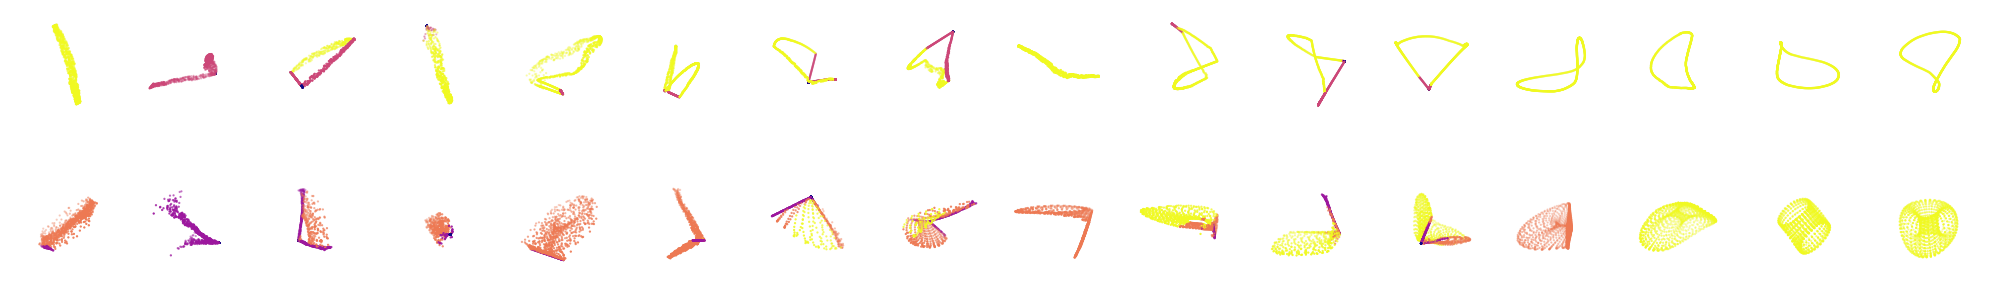

In [761]:
sel_clrs = [clrs[0],clrs[2],clrs[4],clrs[6]]
fig,ax = plt.subplots(2,len(out_dims)*len(in_dims),subplot_kw=dict(projection='3d'),figsize=(20,4))
for i in range(len(out_dims)):
    for j in range(len(in_dims)):
        ax[0,i*len(out_dims)+j].scatter(S1_mflds[i*len(out_dims)+j][:,0],
                                        S1_mflds[i*len(out_dims)+j][:,1],
                                        S1_mflds[i*len(out_dims)+j][:,2],
                                        s=0.4,c=region_ranks_S1[j,i,0],cmap='plasma',
                                        vmin=0,vmax=2)
        ax[0,i*len(out_dims)+j].axis('off')
        ax[1,i*len(out_dims)+j].scatter(T2_mflds[i*len(out_dims)+j][:,0],
                                        T2_mflds[i*len(out_dims)+j][:,1],
                                        T2_mflds[i*len(out_dims)+j][:,2], 
                                        s=0.4, c=region_ranks_T2[j,i,0],cmap='plasma',
                                        vmin=0,vmax=3)
        ax[1,i*len(out_dims)+j].axis('off')
fig.tight_layout()

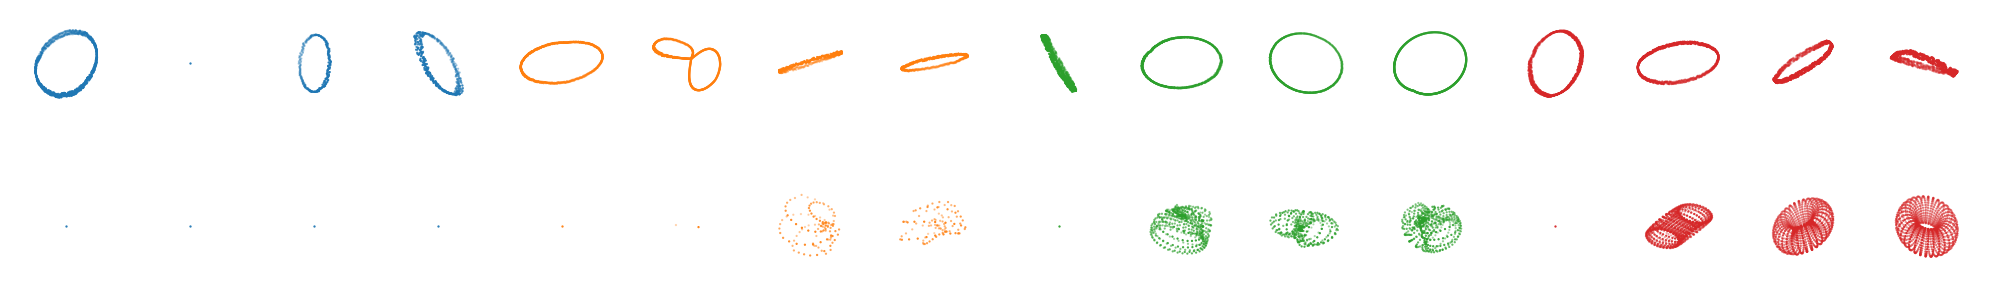

In [762]:
sel_clrs = [clrs[0],clrs[2],clrs[4],clrs[6]]
fig,ax = plt.subplots(2,len(out_dims)*len(in_dims),subplot_kw=dict(projection='3d'),figsize=(20,4))
for i in range(len(out_dims)):
    for j in range(len(in_dims)):
        ax[0,i*len(out_dims)+j].scatter(S1_mflds_rel[i*len(out_dims)+j][:,0],
                                        S1_mflds_rel[i*len(out_dims)+j][:,1],
                                        S1_mflds_rel[i*len(out_dims)+j][:,2],
                                        s=0.4,color=sel_clrs[i])
        ax[0,i*len(out_dims)+j].axis('off')
        ax[1,i*len(out_dims)+j].scatter(T2_mflds_rel[i*len(out_dims)+j][:,0],
                                        T2_mflds_rel[i*len(out_dims)+j][:,1],
                                        T2_mflds_rel[i*len(out_dims)+j][:,2], 
                                        s=0.4, color=sel_clrs[i])
        ax[1,i*len(out_dims)+j].axis('off')
fig.tight_layout()

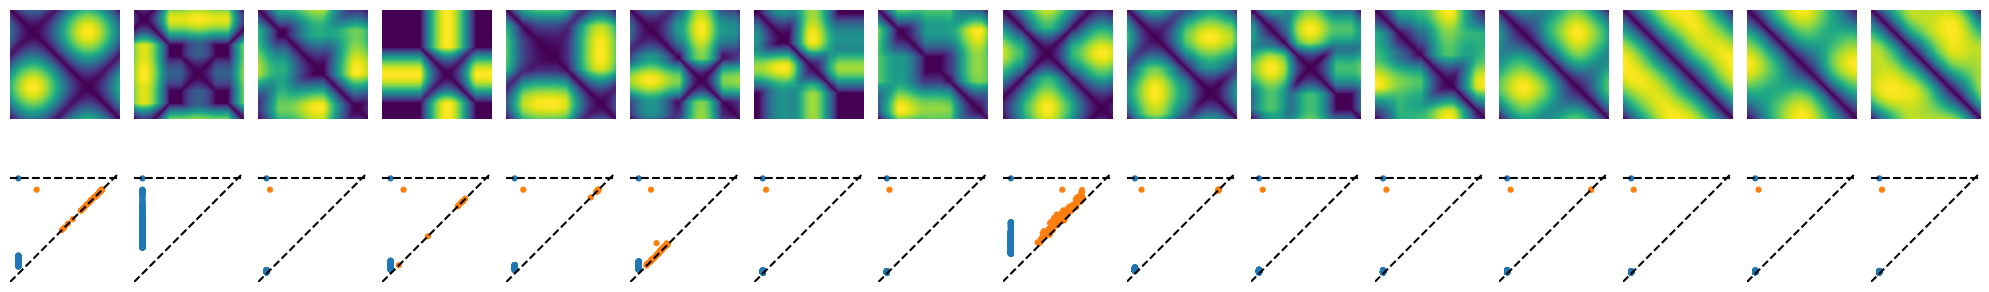

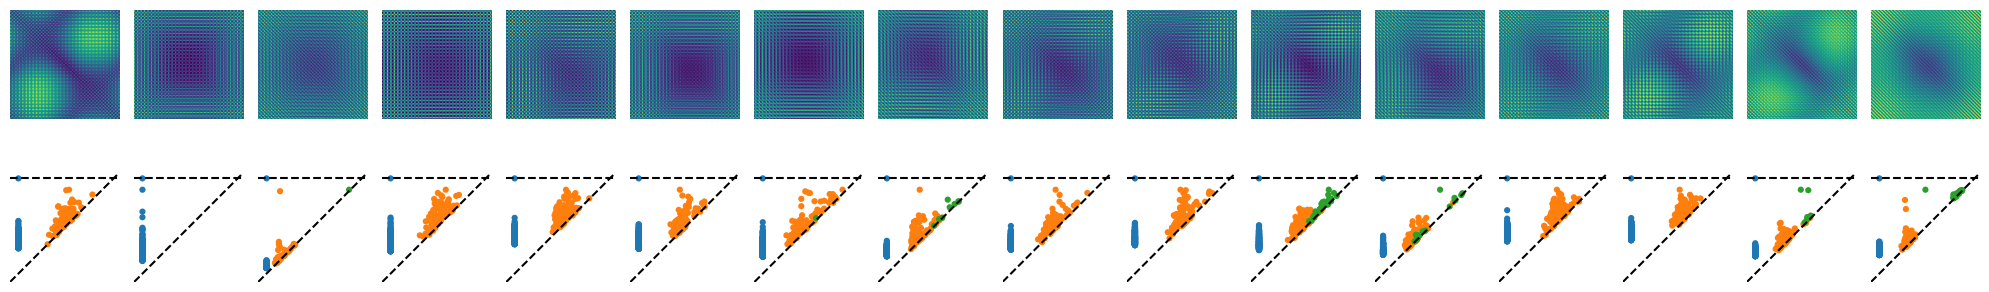

In [763]:
fig,ax = plt.subplots(2,len(out_dims)*len(in_dims),figsize=(20,4))
for i in range(0,16):
    ax[0,i].imshow(S1_dmats[i])
    ax[0,i].axis('off')
    plt.sca(ax[1,i])
    plot_diagrams(S1_pdiags[i],legend=False)
    ax[1,i].axis('off')
fig.tight_layout()

fig2,ax2 = plt.subplots(2,len(out_dims)*len(in_dims),figsize=(20,4))
for i in range(0,16):
    ax2[0,i].imshow(T2_dmats[i])
    ax2[0,i].axis('off')
    plt.sca(ax2[1,i])
    plot_diagrams(T2_pdiags[i],legend=False)
    ax2[1,i].axis('off')
fig2.tight_layout()

/Users/kosio/miniconda3/envs/general_env/lib/python3.11/site-packages/persim/visuals.py:155: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim([x_down, x_up])
/Users/kosio/miniconda3/envs/general_env/lib/python3.11/site-packages/persim/visuals.py:156: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim([y_down, y_up])
/Users/kosio/miniconda3/envs/general_env/lib/python3.11/site-packages/persim/visuals.py:155: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim([x_down, x_up])
/Users/kosio/miniconda3/envs/general_env/lib/python3.11/site-packages/persim/visuals.py:156: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim([y_down, y_up])
/Users/kosio/miniconda3/envs/general_env/lib

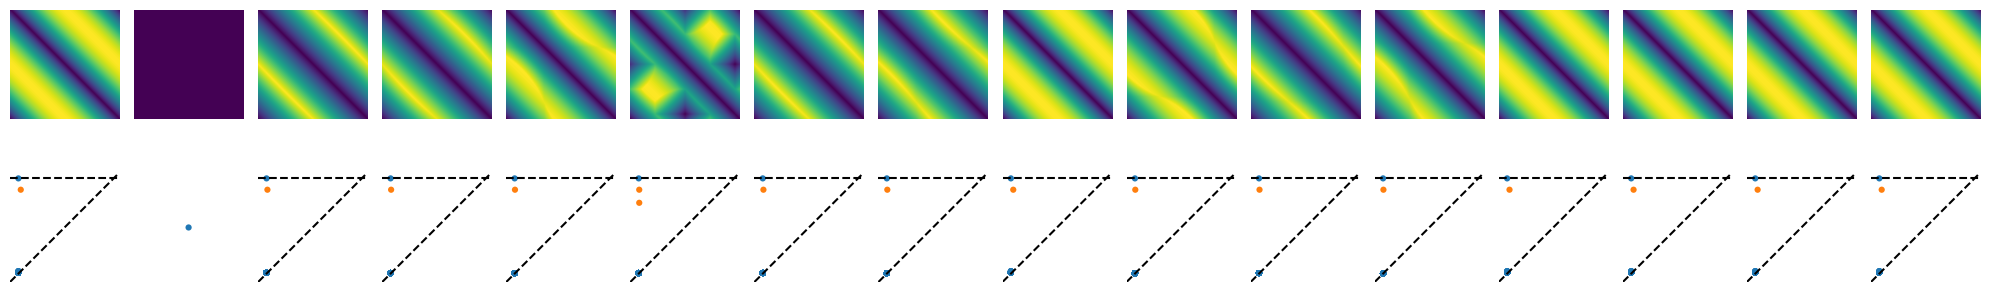

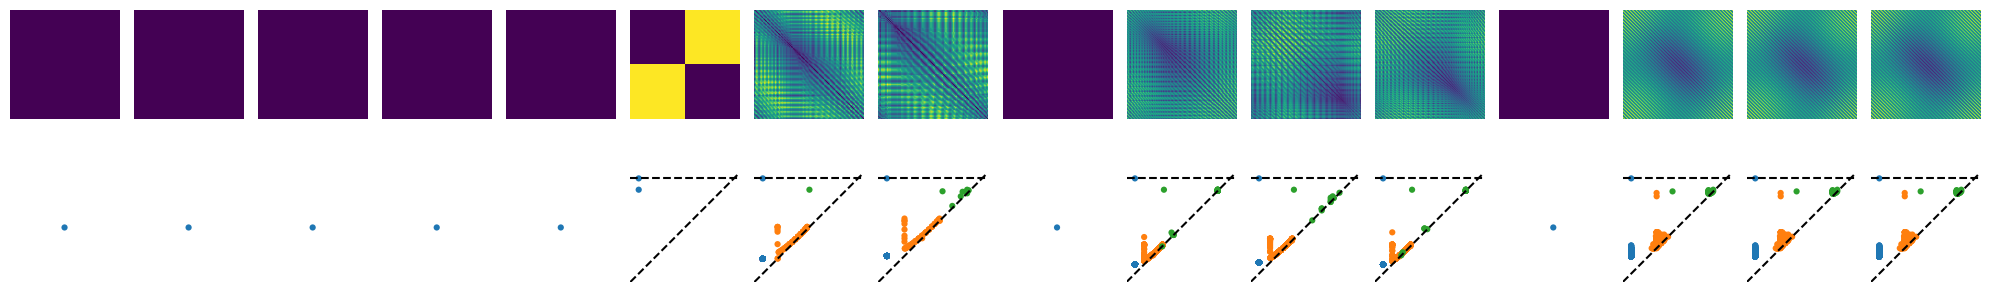

In [764]:
fig,ax = plt.subplots(2,len(out_dims)*len(in_dims),figsize=(20,4))
for i in range(0,16):
    ax[0,i].imshow(S1_dmats_rel[i])
    ax[0,i].axis('off')
    plt.sca(ax[1,i])
    plot_diagrams(S1_pdiags_rel[i],legend=False)
    ax[1,i].axis('off')
fig.tight_layout()

fig2,ax2 = plt.subplots(2,len(out_dims)*len(in_dims),figsize=(20,4))
for i in range(0,16):
    ax2[0,i].imshow(T2_dmats_rel[i])
    ax2[0,i].axis('off')
    plt.sca(ax2[1,i])
    plot_diagrams(T2_pdiags_rel[i],legend=False)
    ax2[1,i].axis('off')
fig2.tight_layout()

In [665]:
#[plt.plot(n_out_theory,region_ranks_theory[i],'-',color=clrs[i]) for i in range(len(n_in_theory))]
#[plt.plot(n_out_theory,region_ranks_stats[i],'.', color=clrs[i]) for i in range(len(n_in_theory))]
#plt.ylim(-0.1,1.1)
[plt.plot(region_ranks_theory[i],region_ranks_stats[i],'o',color=clrs[i]) for i in range(len(n_in_theory))]
plt.plot([0,1],[0,1],'k-')

NameError: name 'n_in_theory' is not defined

In [ ]:
#Markov process transition matrix
from itertools import product
from sklearn.metrics import pairwise_distances

def Markov_transition(n):
    hcube = np.array(list(product([0, 1], repeat=n)))
    Q = pairwise_distances(hcube)
    Q[Q!=1] = 0
    return Q/n

def Markov_dynamics(n,m):
    Q = Markov_transition(n)
    draws = int(np.sum([binom(n,k) for k in range(m)]))
    P = np.zeros([*Q.shape,draws+1])
    P[:,:,0] = np.eye(len(Q))
    for t in range(draws):
        P[:,:,t+1] = P[:,:,t]+P[:,:,t]@Q
    return P
Mark_dyn = Markov_dynamics(7,3)


In [ ]:
plt.imshow(Mark_dyn[:,:,-1])
plt.colorbar()

In [ ]:
#Plots for scaling with index(R)
n_neurons = 100
inpt_dim = [25,50]
R_indxs = np.arange(1,n_neurons,4)#[0,2,3,5,10,50,100,500]
region_min_code = np.zeros([len(R_indxs),len(inpt_dim),n_perms])
theory_curves = np.zeros([n_neurons,len(inpt_dim)])
for r, r_indx in enumerate(R_indxs):
    for n, in_dim in enumerate(inpt_dim):
        for l in range(n_perms):
            x = torch.Tensor(lims*2*(np.random.rand(in_dim, res)-0.5)).T
            rand_model = FeedforwardNetwork(input_size=in_dim,hidden_sizes=[n_neurons])
            R = torch.eye(n_neurons)
            rand_inds = np.random.choice(np.arange(0,n_neurons),size=r_indx, replace=False)
            R[rand_inds,rand_inds] = -1
            rand_model.layers[0].weight = torch.nn.Parameter(rand_model.layers[0].weight)
            #with torch.no_grad():
                #rand_model.layers[0].weight[:49] = -rand_model.layers[0].weight[:49]
            rand_model.layers[0].weight = torch.nn.Parameter(R@rand_model.layers[0].weight)
            out = rand_model(x)[0]
            out_code = torch.sign(out).unique(dim=0)#[torch.sum(out[i]>0,axis=1) for i in range(len(out))]
            region_min_code[r,n,l] = min(rand_model.compute_rank(out_code))#torch.min(out_code[0]).item()
        theory_curves[:,n] = np.concatenate([np.arange(0,int(n_neurons/2)), int(n_neurons/2)-np.arange(0,int(n_neurons/2))])
        theory_curves[:,n] = np.minimum(theory_curves[:,n],in_dim*np.ones(n_neurons))

In [ ]:
#Plots for Dale-scaling with index(R)
inpt_dim = 50
R_indxs_dale = np.arange(1,inpt_dim,1)
region_min_code_dale = np.zeros([len(R_indxs_dale),n_perms])
region_max_code_dale = np.zeros([len(R_indxs_dale),n_perms])
for r, r_indx in enumerate(R_indxs_dale):
    for l in range(n_perms):
        x = torch.Tensor(lims*2*(np.random.rand(inpt_dim, res))).T
        rand_model = FeedforwardNetwork(input_size=inpt_dim,hidden_sizes=[n_neurons])
        R = torch.eye(inpt_dim)
        rand_inds = np.sort(np.random.choice(np.arange(0,inpt_dim),size=r_indx, replace=False))
        R[rand_inds,rand_inds] = -4
        rand_model.layers[0].weight = torch.nn.Parameter(rand_model.layers[0].weight)
        rand_model.layers[0].weight = torch.nn.Parameter(rand_model.layers[0].weight@R)
        out = rand_model(x)[0]
        out_code = torch.sign(out).unique(dim=0)#[torch.sum(out[i]>0,axis=1) for i in range(len(out))]
        code_rank = rand_model.compute_rank(out_code)
        region_min_code_dale[r,l] = min(code_rank)#out_code[0]).item()
        region_max_code_dale[r,l] = max(code_rank)
#balanced_mode = np.logical_or(np.logical_and(np.mean(region_min_code_dale,1)!=0,np.mean(region_min_code_dale,1)!=n_neurons),
#                              np.logical_and(np.mean(region_max_code_dale,1)!=0,np.mean(region_max_code_dale,1)!=n_neurons))
region_min_code_dale[region_min_code_dale>inpt_dim] = inpt_dim
region_max_code_dale[region_max_code_dale>inpt_dim] = inpt_dim
balanced_mode = np.logical_and(np.mean(region_min_code_dale,1)<inpt_dim-1,(np.mean(region_max_code_dale,1)>inpt_dim-1))

In [ ]:
#studying the number of low rank regions as a function of the mean of a distribution and the number of output neurons
means = np.linspace(0,0.2,20)
in_dim = 10

region_ranks_mean = np.zeros([len(out_dims),len(means),n_perms])

for d, dim in enumerate(out_dims):
    for m, mean in enumerate(means):
        for n in range(n_perms):
            x = torch.Tensor(lims*2*(np.random.rand(in_dim, res)-0.5)).T
            rand_model = FeedforwardNetwork(input_size=in_dim,hidden_sizes=[dim],mean=mean,std=std, init_type='normal')
            out = rand_model(x)[0]
            out_code = torch.sign(out).unique(dim=0)#[torch.sum(out[i]>0,axis=1) for i in range(len(out))]
            region_ranks_mean[d,m,n] = min(rand_model.compute_rank(out_code))#sum(out_code[0]<in_dim).item()>0
#min(*[sum(out_code[i]<in_dim).item()>0 for i in range(len(out))])#sum(out_code<in_dim).item()/res#

In [ ]:
depth = 10
in_dim_ = 25
region_ranks_depth = np.zeros([depth,len(out_dims),n_perms])

for m, n_out in enumerate(out_dims):
    print(m)
    for n in range(n_perms):
        ranks_at_points = np.zeros([depth,res])
        x = torch.Tensor(lims*2*(np.random.rand(in_dim_, res)-0.5)).T
        rand_model = FeedforwardNetwork(input_size=in_dim_,hidden_sizes=[n_out for k in range(depth)],mean=1,std=1,init_type='normal')
        for i,x_i in enumerate(x):
            ranks_at_points[:,i] = rand_model.compute_rank_at_point(x_i)
        region_ranks_depth[:,m,n] = np.min(ranks_at_points,1)

In [ ]:
plt.imshow(ranks_at_points)

In [ ]:
plt.plot(np.mean(region_ranks_depth,2))

In [ ]:
fig_height = 11.7/7
fig_width = 8.3/1.3
clrs = plt.cm.tab20.colors
plt.rcParams["font.family"] = "Arial"

fig, ax = plt.subplots(1,4,figsize=(fig_width,fig_height))#,dpi=300)

for k in range(len(out_dims)):
    ax[0].plot(out_dims, np.mean(region_ranks,2)[k],'-o',color=clrs[k],markersize=4)
    #ax[0].fill_between(out_dims, np.mean(region_ranks,2)[k]-np.std(region_ranks,2)[k],
    #                   np.mean(region_ranks,2)[k]+np.std(region_ranks,2)[k], color=clrs[k],alpha=0.2)
    ax[0].plot(out_dims, in_dims[k]*np.ones(len(out_dims)),'--',color=clrs[k],lw=0.5)
    #ax[0].plot([in_dims[k],in_dims[k]], [0,out_dims[k]],'--',color=clrs[k],lw=0.5)
    
#ax[0].set_xlabel('$n_1$')
ax[0].set_xscale('log')
ax[0].set_yscale('log')
#ax[0].set_ylabel('$P[rank(\Phi^1)<m]$')

for k in range(len(out_dims)):
    ax[1].plot(means,np.mean(region_ranks_mean[k],1),'-o',color=clrs[k],markersize=4)
ax[1].plot(means,in_dim*np.ones(len(means)),'k')
#ax[1].set_yscale('log')


ax[2].plot(theory_curves[:,0],'k',lw=4)
ax[2].plot(theory_curves[:,1],'k',lw=4)
ax[2].plot(R_indxs, np.mean(region_min_code[:,0],1),'-',color='cyan',lw=2,alpha=1)
ax[2].plot(R_indxs, np.mean(region_min_code[:,1],1),'-',color='orange',lw=2,alpha=1)
#ax[2].errorbar(R_indxs, np.mean(region_min_code,1),yerr=1*np.std(region_min_code,1),color='red', fmt='none',markersize=4)

ax[2].set_ylim(-1,51)
#ax[1].set_xlabel('indx($R$)')
#ax[0,1].set_xscale('log')
#ax[1].set_ylabel('$min(C_{J})$')
#ax[0,1].set_yscale('log')
#ax[0,0].legend(in_dims)

ax[3].plot(R_indxs_dale, np.mean(region_min_code_dale,1),'-',color='blue',lw=2.5,alpha=0.7)
ax[3].plot(R_indxs_dale, np.mean(region_max_code_dale,1),'-',color='red',lw=2.5,alpha=0.7)
#ax[3].fill_between(R_indxs,
#                   np.mean(region_min_code_dale,1)-4*np.std(region_min_code_dale,1),
#                   np.mean(region_min_code_dale,1)+4*np.std(region_min_code_dale,1),
#                   alpha=0.5,color='red',zorder=100)
#ax[3].errorbar(R_indxs, np.mean(region_min_code_dale,1),yerr=1*np.std(region_min_code_dale,1),color='red', fmt='none',markersize=4)
ax[3].fill_betweenx(np.arange(-10,60),R_indxs_dale[balanced_mode][0],R_indxs_dale[balanced_mode][-1],alpha=0.2,color='purple')
ax[3].set_ylim(-1,51)

#ax[2].set_xlabel('$\mu$')
#ax[2].set_ylabel('$P[rank(\Phi^1)<m]$')

#for k in range(len(R_indxs_2)):
#    ax[3].plot(np.arange(1,depth+1), np.mean(region_ranks_depth[:,k],1),'-o',color=clrs[k],markersize=4)
#ax[3].set_xlabel('depth')
fig.tight_layout()
fig.savefig("/Users/kosio/Figures/MfldClassification/top_destr.png",dpi=500, transparent=True)